In [74]:
"""
Batch Normalization
This notebook contains an implementation of a deep fully-connected neural network with batch normalization,
applied to the problem of multi-class classification of handwritten digits.
The training and test sets are ready to use as part of the MNIST dataset containing greyscale images of digits.
Link to the dataset: http://yann.lecun.com/exdb/mnist/

The original reason for making this notebook was to practice batch normalization by implementing it from scratch.
This happened while I was following the Deep Learning specialization on Coursera,
specifically the second course called "Improving Deep Neural Networks",
in which Batch normalization is described but not implemented as part of an assignment.

Implemented from scratch with extensive use of the Numpy library, the network contains:
- Configurable number of layers and units for each layer,
- ReLU activations for all layers except the last, while the last layer uses the Softmax activation,
- Categorical cross-entropy loss function,
- Adam optimizer as a gradient descent based optimization method,
- Mini-batches,
- Batch-normalization,
- Learning rate decay.
"""

'\nBatch Normalization\nThis notebook contains an implementation of a deep fully-connected neural network with batch normalization,\napplied to the problem of multi-class classification of handwritten digits.\nThe training and test sets are ready to use as part of the MNIST dataset containing greyscale images of digits.\nLink to the dataset: http://yann.lecun.com/exdb/mnist/\n\nThe original reason for making this notebook was to practice batch normalization by implementing it from scratch.\nThis happened while I was following the Deep Learning specialization on Coursera,\nspecifically the second course called "Improving Deep Neural Networks",\nin which Batch normalization is described but not implemented as part of an assignment.\n\nImplemented from scratch with extensive use of the Numpy library, the network contains:\n- Configurable number of layers and units for each layer,\n- ReLU activations for all layers except the last, while the last layer uses the Softmax activation,\n- Categ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import math

In [2]:
# LOAD TRAIN EXAMPLES

In [3]:
with open("datasets/train-images.idx3-ubyte", 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    n_rows, n_cols = struct.unpack(">II", f.read(8))
    x_train_orig = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>')).reshape((size, n_rows, n_cols))

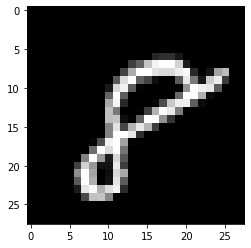

In [4]:
plt.imshow(x_train_orig[size-1, :, :], cmap='gray')
plt.show()

In [5]:
print("number of train examples: " + str(size))
print("rows: " + str(n_rows))
print("cols: " + str(n_cols))

number of train examples: 60000
rows: 28
cols: 28


In [6]:
# LOAD TRAIN LABELS

In [7]:
with open("datasets/train-labels.idx1-ubyte", 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_train_orig = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>')).reshape((1, -1))

In [8]:
print("number of train labels: " + str(size))
print(y_train_orig[0, size-1])

number of train labels: 60000
8


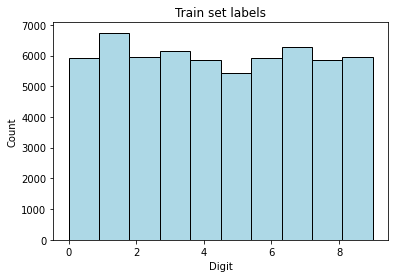

In [9]:
n, bins, patches = plt.hist(y_train_orig.reshape((-1,)), 10, facecolor='lightblue', edgecolor='black')
plt.title('Train set labels')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

In [10]:
# LOAD TEST EXAMPLES

In [11]:
with open("datasets/t10k-images.idx3-ubyte", 'rb') as f:
    magic, size_test = struct.unpack(">II", f.read(8))
    n_rows, n_cols = struct.unpack(">II", f.read(8))
    x_test_orig = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>')).reshape((size_test, n_rows, n_cols))

In [12]:
# LOAD TEST LABELS

In [13]:
with open("datasets/t10k-labels.idx1-ubyte", 'rb') as f:
    magic, size_test = struct.unpack(">II", f.read(8))
    y_test_orig = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>')).reshape((1, -1))

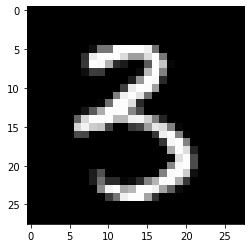

In [14]:
plt.imshow(x_test_orig[5000, :, :], cmap='gray')
plt.show()

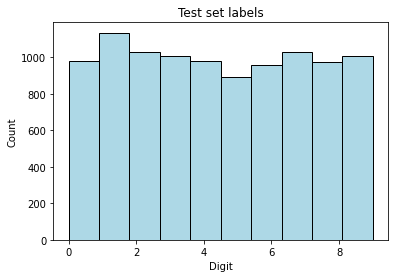

In [15]:
n, bins, patches = plt.hist(y_test_orig.reshape((-1,)), 10, facecolor='lightblue', edgecolor='black')
plt.title('Test set labels')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

In [16]:
# Reshape the training and test examples
# The "-1" makes reshape flatten the remaining dimensions
x_train_flat = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flat = x_test_orig.reshape(x_test_orig.shape[0], -1).T

In [17]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z)), Z

def relu(Z):
    return np.maximum(Z, 0), Z

def softmax(Z):
    Z_shifted = Z - np.max(Z)
    T = np.exp(Z_shifted)
    return T / np.sum(T, axis=0), Z


mat = np.array([[5, 2, -1, 3], [5, 2, -1, 3], [5, 2, -1, 3]]).T
print(mat)

print(sigmoid(mat))
print(relu(mat))
print(softmax(mat))

[[ 5  5  5]
 [ 2  2  2]
 [-1 -1 -1]
 [ 3  3  3]]
(array([[0.99330715, 0.99330715, 0.99330715],
       [0.88079708, 0.88079708, 0.88079708],
       [0.26894142, 0.26894142, 0.26894142],
       [0.95257413, 0.95257413, 0.95257413]]), array([[ 5,  5,  5],
       [ 2,  2,  2],
       [-1, -1, -1],
       [ 3,  3,  3]]))
(array([[5, 5, 5],
       [2, 2, 2],
       [0, 0, 0],
       [3, 3, 3]]), array([[ 5,  5,  5],
       [ 2,  2,  2],
       [-1, -1, -1],
       [ 3,  3,  3]]))
(array([[0.84203357, 0.84203357, 0.84203357],
       [0.04192238, 0.04192238, 0.04192238],
       [0.00208719, 0.00208719, 0.00208719],
       [0.11395685, 0.11395685, 0.11395685]]), array([[ 5,  5,  5],
       [ 2,  2,  2],
       [-1, -1, -1],
       [ 3,  3,  3]]))


In [18]:
def one_hot_encoding(labels, depth):
    one_hot = np.zeros((depth, labels.size))
    one_hot[labels, np.arange(labels.size)] = 1
    return one_hot

why_samples = np.array([2, 4, 6, 6]).reshape((1, -1))
print(why_samples)
print(one_hot_encoding(why_samples, 10))

[[2 4 6 6]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [19]:
def categorical_cross_entropy(AL, Y_one_hot):
    """
    The categorial cross-entropy cost function that computes the losses from aL and y.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (num_classes, number of examples)
    Y -- true "label" vector (for example: containing a digit), shape (num_classes, number of examples)

    Returns:
    cost -- cost
    """
    
    m = Y_one_hot.shape[1]
    cost = -1 / m * np.sum(Y_one_hot * np.log(AL + 1e-15))
    
    return cost

In [86]:
def random_mini_batches(X, Y, mini_batch_size = 256):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((-1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_mini_batches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_mini_batches):
        mini_batch_X = shuffled_X[:, k * inc:(k+1) * inc]
        mini_batch_Y = shuffled_Y[:, k * inc:(k+1) * inc]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, inc * num_complete_mini_batches:]
        mini_batch_Y = shuffled_Y[:, inc * num_complete_mini_batches:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [84]:
def exponential_update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    learning_rate = 1 / (1 + decay_rate * epoch_num) * learning_rate0
    return learning_rate

In [22]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=10):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    learning_rate = 1 / (1 + decay_rate * np.floor(epoch_num / time_interval)) * learning_rate0
    return learning_rate

In [23]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing parameters "W1", "beta1", "gamma1", ..., "WL", "betaL", "gammaL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    betal -- bias vector of shape (layer_dims[l], 1)
                    gammal -- bias vector of shape (layer_dims[l], 1)
    """
    
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        # For ReLU layers initialize weights by multiplying gaussian with np.sqrt(2.0 / layer_dims[l-1])
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2.0 / layer_dims[l-1])
        parameters['beta' + str(l)] = np.zeros((layer_dims[l], 1))
        parameters['gamma' + str(l)] = np.ones((layer_dims[l], 1))

    return parameters

In [24]:
def batch_norm(Z, beta, gamma, running_mean = None, running_var = None, epsilon = 1e-15):
    """
    During training, mini-batch mean and variance is calculated from the input.
    During testing, running mean and variance is provided instead.
    """
    m = Z.shape[1]
    
    if running_mean is None or running_var is None:
        mean = 1. / m * np.sum(Z, axis=1, keepdims=True)
        Zmean = Z - mean
        sq = Zmean**2
        var = 1. / m * np.sum(sq, axis=1, keepdims=True)
    else:
        mean = running_mean
        Zmean = Z - mean
        sq = Zmean**2
        var = running_var
    
    sqrtvar = np.sqrt(var + epsilon)
    ivar = 1./sqrtvar
    Z_normalized = Zmean * ivar
    Z_gamma = gamma * Z_normalized
    Z_tilde = Z_gamma + beta
    
    cache = (Z, Z_normalized, gamma, Zmean, ivar, sqrtvar, epsilon, mean, var)
    
    return Z_tilde, cache

In [25]:
def linear_forward(A, W):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", and "W"; stored for computing the backward pass efficiently
    """
    
    Z = W @ A
    cache = (A, W)
    
    return Z, cache

In [26]:
def linear_activation_forward(A_prev, W, beta, gamma, activation, layer_mean, layer_var):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid", "relu" or "softmax"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    Z, linear_cache = linear_forward(A_prev, W)
    
    # normalize mini-batch
    Z_tilde, batch_norm_cache = batch_norm(Z, beta, gamma, layer_mean, layer_var)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z_tilde)
    elif activation == "relu":
        A, activation_cache = relu(Z_tilde)
    elif activation == "softmax":
        A, activation_cache = softmax(Z_tilde)
        
    cache = (linear_cache, activation_cache, batch_norm_cache)

    return A, cache

In [27]:
def L_model_forward(X, parameters, L, means_per_layer = None, variances_per_layer = None):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->[LINEAR->SOFTMAX] computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    
    # means and variances per layer (relevant only during training)
    means = []
    variances = []
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        layer_mean = None if means_per_layer is None else means_per_layer[l-1]
        layer_var = None if variances_per_layer is None else variances_per_layer[l-1] 
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['beta' + str(l)],
                                             parameters['gamma' + str(l)], 'relu', layer_mean, layer_var)
        _, _, batch_norm_cache = cache
        _, _, _, _, _, _, _, mean, var = batch_norm_cache
        means.append(mean)
        variances.append(var)
        caches.append(cache)
    
    # Implement LINEAR -> SOFTMAX. Add "cache" to the "caches" list.
    layer_mean = None if means_per_layer is None else means_per_layer[L-1]
    layer_var = None if variances_per_layer is None else variances_per_layer[L-1]
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['beta' + str(L)],
                                          parameters['gamma' + str(L)], 'softmax', layer_mean, layer_var)
    _, _, batch_norm_cache = cache
    _, _, _, _, _, _, _, mean, var = batch_norm_cache
    means.append(mean)
    variances.append(var)
    caches.append(cache)
          
    return AL, caches, means, variances

In [28]:
def compute_cost(AL, Y_one_hot, parameters, lambd):
    m = Y_one_hot.shape[1]
    
    cross_entropy = categorical_cross_entropy(AL, Y_one_hot)
    
    # Add L2 regularization cost based on parameters W
    num_layers = len(parameters) // 3
    all_W = np.concatenate(tuple([parameters["W" + str(l)] for l in range(1, num_layers+1)]), axis=None)
    L2_regularization_cost = lambd / (2 * m) * np.sum(np.square(all_W))
    
    return cross_entropy + L2_regularization_cost

In [29]:
def final_softmax_layer_backward(Y_one_hot, AL, cache, lambd):
    linear_cache, _, batch_norm_cache = cache
    
    dZL_tilde = AL - Y_one_hot
    dZL, dbeta, dgamma = batch_norm_backward(dZL_tilde, batch_norm_cache)
    dA_prev, dW = linear_backward(dZL, linear_cache, lambd)
    
    return dA_prev, dW, dbeta, dgamma

In [30]:
def linear_activation_backward(dA, cache, activation, lambd):
    linear_cache, activation_cache, batch_norm_cache = cache
    
    if activation == "relu":
        dZ_tilde = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ_tilde = sigmoid_backward(dA, activation_cache)
        
    dZ, dbeta, dgamma = batch_norm_backward(dZ_tilde, batch_norm_cache)
    dA_prev, dW = linear_backward(dZ, linear_cache, lambd)
    
    return dA_prev, dW, dbeta, dgamma

In [31]:
def sigmoid_backward(dA, Z):
    s, _ = sigmoid(Z)
    return dA * s * (1 - s)

def relu_backward(dA, Z):
    return dA * np.greater(Z, 0).astype(int)

In [32]:
def batch_norm_backward(dZ_tilde, batch_norm_cache):
    Z, Z_normalized, gamma, Zmean, ivar, sqrtvar, epsilon, mean, var = batch_norm_cache
    
    m = dZ_tilde.shape[1]
    
    dbeta = np.sum(dZ_tilde, axis=1, keepdims=True)
    dgamma = np.sum(dZ_tilde * Z_normalized, axis=1, keepdims=True)
    
    dZ_normalized = dZ_tilde * gamma
    divar = np.sum(dZ_normalized * Zmean, axis=1, keepdims=True)
    dxmu1 = dZ_normalized * ivar
    dsqrtvar = -1. /(sqrtvar**2) * divar
    dvar = 0.5 * 1. /np.sqrt(var + epsilon) * dsqrtvar
    dsq = 1. / m * np.ones(dZ_tilde.shape) * dvar
    dxmu2 = 2 * Zmean * dsq
    dZ1 = dxmu1 + dxmu2
    dmu = -1 * np.sum(dZ1, axis=1, keepdims=True)
    dZ2 = 1. / m * np.ones(dZ_tilde.shape) * dmu
    dZ = dZ1 + dZ2

    #t = 1. / np.sqrt(var + eps)
    #dZ = (gamma * t / m) * (m * dZ_tilde - dbeta - t**2 * (Z - mean) * np.sum(dZ_tilde * (Z - mean), axis=1, keepdims=True))
    
    return dZ, dbeta, dgamma

In [33]:
def linear_backward(dZ, linear_cache, lambd):
    A_prev, W = linear_cache
    m = A_prev.shape[1]

    dW = 1.0/m * dZ @ A_prev.T + lambd / m * W
    dA_prev = W.T @ dZ
    
    return dA_prev, dW

In [34]:
def L_model_backward(AL, Y, caches, lambd):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, dbeta_temp, dgamma_temp = final_softmax_layer_backward(Y, AL, current_cache, lambd)
    grads["dW" + str(L)] = dW_temp
    grads["dbeta" + str(L)] = dbeta_temp
    grads["dgamma" + str(L)] = dgamma_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, dbeta_temp, dgamma_temp = linear_activation_backward(dA_prev_temp, current_cache, 'relu', lambd)
        grads["dW" + str(l + 1)] = dW_temp
        grads["dbeta" + str(l + 1)] = dbeta_temp
        grads["dgamma" + str(l + 1)] = dgamma_temp

    return grads

In [35]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 3 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        W_shape = parameters["W" + str(l)].shape
        beta_shape = parameters["beta" + str(l)].shape
        gamma_shape = parameters["gamma" + str(l)].shape
        v["dW" + str(l)] = np.zeros(W_shape)
        v["dbeta" + str(l)] = np.zeros(beta_shape)
        v["dgamma" + str(l)] = np.zeros(gamma_shape)
        s["dW" + str(l)] = np.zeros(W_shape)
        s["dbeta" + str(l)] = np.zeros(beta_shape)
        s["dgamma" + str(l)] = np.zeros(gamma_shape)
    
    return v, s

In [36]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 3                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["dbeta" + str(l)] = beta1 * v["dbeta" + str(l)] + (1 - beta1) * grads["dbeta" + str(l)]
        v["dgamma" + str(l)] = beta1 * v["dgamma" + str(l)] + (1 - beta1) * grads["dgamma" + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1**t)
        v_corrected["dbeta" + str(l)] = v["dbeta" + str(l)] / (1 - beta1**t)
        v_corrected["dgamma" + str(l)] = v["dgamma" + str(l)] / (1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * grads["dW" + str(l)]**2
        s["dbeta" + str(l)] = beta2 * s["dbeta" + str(l)] + (1 - beta2) * grads["dbeta" + str(l)]**2
        s["dgamma" + str(l)] = beta2 * s["dgamma" + str(l)] + (1 - beta2) * grads["dgamma" + str(l)]**2

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2**t)
        s_corrected["dbeta" + str(l)] = s["dbeta" + str(l)] / (1 - beta2**t)
        s_corrected["dgamma" + str(l)] = s["dgamma" + str(l)] / (1 - beta2**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] -= learning_rate * (v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon))
        parameters["beta" + str(l)] -= learning_rate * (v_corrected["dbeta" + str(l)] / (np.sqrt(s_corrected["dbeta" + str(l)]) + epsilon))
        parameters["gamma" + str(l)] -= learning_rate * (v_corrected["dgamma" + str(l)] / (np.sqrt(s_corrected["dgamma" + str(l)]) + epsilon))

    return parameters, v, s, v_corrected, s_corrected

In [88]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 50,
                  lambd = 0.7, momentum = 0.9, print_cost=True, decay=None, decay_rate=1):
    costs = []  # keep track of cost
    
    parameters = initialize_parameters_deep(layer_dims)
    v, s = initialize_adam(parameters)
    t = 0  # initializing the counter required for Adam update
    
    Y_one_hot = one_hot_encoding(Y, num_classes)
    m = Y.shape[1]
    L = len(layer_dims) - 1
    
    learning_rate0 = learning_rate   # the original learning rate
    
    # Optimization loop
    for i in range(num_iterations):
        mini_batches = random_mini_batches(X, Y_one_hot)
        cost_total = 0
        running_means_per_layer = [np.zeros((layer_dims[l+1], 1)) for l in range(L)]
        running_vars_per_layer = [np.zeros((layer_dims[l+1], 1)) for l in range(L)]
        
        for b, mini_batch in enumerate(mini_batches):

            # Select a minibatch
            (mini_batch_X, mini_batch_Y) = mini_batch

            # Forward propagation
            AL, caches, means_per_layer, variances_per_layer = L_model_forward(mini_batch_X, parameters, L)
            
            # Update running averages across mini-batches (per layer)
            for l in range(L):
                running_means_per_layer[l] = momentum * running_means_per_layer[l] + (1 - momentum) * means_per_layer[l]
                running_vars_per_layer[l] = momentum * running_vars_per_layer[l] + (1 - momentum) * variances_per_layer[l]
                
            # Compute cost and add to the cost total
            cost_total += compute_cost(AL, mini_batch_Y, parameters, lambd)

            # Backward propagation
            grads = L_model_backward(AL, mini_batch_Y, caches, lambd)

            # Update parameters
            t += 1  # Adam counter
            parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)
            
        cost_avg = cost_total / m
        
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        
        # Store the cost every n number of epochs
        if i == 0 or i % 5 == 0 or i == num_iterations - 1:
            costs.append(cost_avg)
            if print_cost:
                print ("Cost after epoch %i: %f" %(i, cost_avg))
    
    return parameters, costs, running_means_per_layer, running_vars_per_layer

In [38]:
def predict(X, parameters, L, means_per_layer, vars_per_layer):
    AL, _, _, _ = L_model_forward(X, parameters, L, means_per_layer, vars_per_layer)
    return np.argmax(AL, axis=0, keepdims=True)

In [39]:
def accuracy(X, Y, parameters, L, means_per_layer, vars_per_layer):
    return np.sum(predict(X, parameters, L, means_per_layer, vars_per_layer) == Y) / X.shape[1]

In [40]:
# CHECK BN FORWARD PASS

In [59]:
# Credits to Standford course cs231n for this block of code.
# https://cs231n.github.io/assignments2022/assignment2/

# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
M, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(D1, M)
W1 = np.random.randn(D2, D1)
W2 = np.random.randn(D3, D2)
a = W2.dot(np.maximum(0, W1.dot(X)))

print('Before batch normalization:')
print('  means: ', a.mean(axis=1))
print('  stds: ', a.std(axis=1))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batch_norm(a, np.zeros((D3, 1)), np.ones((D3, 1)))
a_norm_mean = a_norm.mean(axis=1)
a_norm_std = a_norm.std(axis=1)
print('  mean: ', a_norm_mean)
print('  std: ', a_norm_std)

assert np.isclose(a_norm_mean, np.zeros(a_norm_mean.shape)).all()
assert np.isclose(a_norm_std, np.ones(a_norm_mean.shape)).all()

# Now means should be close to beta and stds close to gamma
beta = np.asarray([[11.0], [12.0], [13.0]])
gamma = np.asarray([[1.0], [2.0], [3.0]])
a_norm, _ = batch_norm(a, beta, gamma)
a_norm_mean = a_norm.mean(axis=1)
a_norm_std = a_norm.std(axis=1)
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm_mean)
print('  stds: ', a_norm_std)

assert np.isclose(a_norm_mean, beta.flatten()).all()
assert np.isclose(a_norm_std, gamma.flatten()).all()

Before batch normalization:
  means:  [ 17.38546145 -28.21498249  55.02474629]
  stds:  [32.98591027 31.65106098 31.74463317]
After batch normalization (gamma=1, beta=0)
  mean:  [7.10542736e-17 4.88498131e-17 9.76996262e-17]
  std:  [1. 1. 1.]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [1. 2. 3.]


In [75]:
# Credits to Standford course cs231n for this block of code.
# https://cs231n.github.io/assignments2022/assignment2/

# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

M, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D2, D1)
W2 = np.random.randn(D3, D2)

gamma = np.ones((D3, 1))
beta = np.zeros((D3, 1))
for t in range(50):
    X = np.random.randn(D1, M)
    a = W2.dot(np.maximum(0, W1.dot(X)))
    a_norm, cache = batch_norm(a, beta, gamma)

_, _, _, _, _, _, _, mean, var = cache

X = np.random.randn(D1, M)
a = W2.dot(np.maximum(0, W1.dot(X)))
a_norm, _ = batch_norm(a, beta, gamma, mean, var)
a_norm_mean = a_norm.mean(axis=1)
a_norm_std = a_norm.std(axis=1)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm_mean)
print('  stds: ', a_norm_std)

assert np.isclose(a_norm_mean, np.zeros(a_norm_mean.shape), atol=.255).all()
assert np.isclose(a_norm_std, np.ones(a_norm_mean.shape), atol=.15).all()

After batch normalization (test-time):
  means:  [-0.02951383  0.10758225 -0.13066542]
  stds:  [0.91736387 1.04711055 0.95737263]


In [43]:
# CHECK BN BACKWARD PASS

In [81]:
# Credits to Standford course cs231n for this block of code.
# https://cs231n.github.io/assignments2022/assignment2/

# Gradient check batchnorm backward pass

from random import randrange


def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  print("Shape of grad is ", grad.shape)
  return grad


def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


D, M = 5, 4
x = 5 * np.random.randn(D, M) + 12
gamma = np.random.randn(D, 1)
beta = np.random.randn(D, 1)
dout = np.random.randn(D, M)

fx = lambda x: batch_norm(x, beta, gamma)[0]
fg = lambda a: batch_norm(x, beta, gamma)[0]
fb = lambda b: batch_norm(x, beta, gamma)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batch_norm(x, beta, gamma)
dx, dbeta, dgamma = batch_norm_backward(dout, cache)
print("Shape of dx is ", dx.shape)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

grad = np.concatenate((dx.flatten(), dgamma.flatten(), dbeta.flatten()))
gradapprox = np.concatenate((dx_num.flatten(), da_num.flatten(), db_num.flatten()))

numerator = np.linalg.norm(grad - gradapprox)
denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)
difference = numerator / denominator

if difference > 2e-7:
    print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
else:
    print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")


Shape of grad is  (5, 4)
Shape of grad is  (5, 1)
Shape of grad is  (5, 1)
Shape of dx is  (5, 4)
dx error:  4.5740574144533545e-10
dgamma error:  1.176717928039398e-09
dbeta error:  7.871800462910199e-12
Your backward propagation works perfectly fine! difference = 1.2156157823905741e-11


In [45]:
# TRAIN MODEL WITH BN

Cost after epoch 0: 0.005037
Cost after epoch 5: 0.001887
Cost after epoch 10: 0.001383
Cost after epoch 15: 0.001140
Cost after epoch 20: 0.001024
Cost after epoch 25: 0.000894
Cost after epoch 30: 0.001452
Cost after epoch 35: 0.001201
Cost after epoch 40: 0.001036
Cost after epoch 45: 0.000967
Cost after epoch 50: 0.000948
Cost after epoch 55: 0.000821
Cost after epoch 60: 0.000765
Cost after epoch 65: 0.000669
Cost after epoch 70: 0.000601
Cost after epoch 74: 0.000568
Train set accuracy: 98.04333333333334%
Test set accuracy: 96.78%


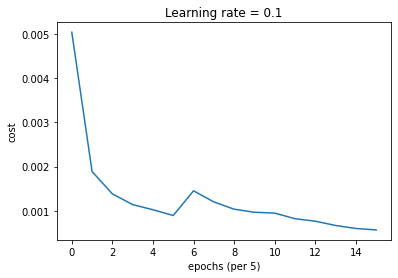

In [95]:
x_train = x_train_flat[:,:]/255.
y_train = y_train_orig[:,:]
x_test = x_test_flat[:,:]/255.
y_test = y_test_orig[:,:]

#print("mean of x_train on a few examples: " + str(x_train.mean(axis=1, keepdims=True)))
#print("var of x_train on a few examples: " + str(x_train.var(axis=1, keepdims=True)))

learning_rate = 0.1
num_classes = 10
layer_dims = [n_rows*n_cols, 110, num_classes]
L = len(layer_dims) - 1

parameters, costs, means_per_layer, vars_per_layer = L_layer_model(x_train, y_train, layer_dims, learning_rate,
                                                                   num_iterations = 75, lambd = 0.7,
                                                                   momentum = 0.9, print_cost=True, 
                                                                   decay=exponential_update_lr, decay_rate=0.6)


#print("moving mean on a few examples: " + str(means_per_layer))
#print("moving var on a few examples: " + str(vars_per_layer))

print("Train set accuracy: {}%".format(accuracy(x_train, y_train, parameters, L, means_per_layer, vars_per_layer) * 100.0))
print("Test set accuracy: {}%".format(accuracy(x_test, y_test, parameters, L, means_per_layer, vars_per_layer) * 100.0))

# plot the cost
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('epochs (per 5)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()